## Установка и импорт модулей

In [ ]:
!nvidia-smi

Sun May 26 12:55:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%env SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True

env: SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True


In [ ]:
!pip install pymorphy2 bertopic evaluate transformers[torch]

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import random
import os
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim import corpora, models
%matplotlib inline
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from transformers.pipelines import pipeline
import tensorflow_hub
from pymystem3 import Mystem

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(42)

## Загрузка и обработка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class AutoLoader:
    def __init__(self):
        self.data = pd.DataFrame([], columns=['group_id', 'post_id', 'text', 'description', 'date'])
        nltk.download('stopwords')
        self.patterns = re.compile(r'[^а-яА-ЯёЁ ]+')
        self.stopwords_ru = set(stopwords.words("russian"))
        self.morph = MorphAnalyzer()
        self.antiscience_pubs = {
            'Название паблика': 'group_id',
        }
        self.science_pubs = {
            'Название паблика': 'group_id',
        }
        self.neutral_pubs = {
            'Название паблика': 'group_id',
        }
        self.inv_antiscience_pubs = {v: k for k, v in self.antiscience_pubs.items()}
        self.inv_science_pubs = {v: k for k, v in self.science_pubs.items()}
        self.inv_neutral_pubs = {v: k for k, v in self.neutral_pubs.items()}
        self.all_pubs = dict(list(self.inv_antiscience_pubs.items()) + list(self.inv_science_pubs.items()) + list(self.inv_neutral_pubs.items()))

    def __clear(self, doc, tokenize, lemmatize):
        doc = re.sub(self.patterns, ' ', doc)
        raw_tokens = doc.split()
        tokens = []
        if len(raw_tokens) <= 5:
            return None

        for token in raw_tokens:
            token = token.strip()
            if tokenize:
                if token not in self.stopwords_ru:
                    tokens.append(token)
            else:
                tokens.append(token)
        if tokenize:
            return tokens
        else:
            return ' '.join(tokens)

    def load_file(self, file_path, drop_na=True, clear=True, tokenize=False, lemmatize=False):
        data_from_file = pd.read_csv(file_path, index_col=0)
            # .rename(columns={'0' : 'domain', '1' : 'post_id', '2' : 'raw_text'})
        data_from_file['type'] = data_from_file.group_id.apply(lambda id: 2 if id in self.inv_science_pubs else 0 if id in self.inv_antiscience_pubs else 1)
        data_from_file['pub_name'] = data_from_file.group_id.apply(lambda id: self.all_pubs[id])
        if drop_na:
            data_from_file.dropna(inplace=True)
        if clear:
            data_from_file['tokenized_text'] = data_from_file['text'].apply(self.__clear, tokenize=tokenize, lemmatize=lemmatize)
            if drop_na:
                data_from_file.dropna(inplace=True)

        self.data = pd.concat([self.data, data_from_file], ignore_index=True)

    def load_dir(self, path_dir, drop_na=True, clear=True, tokenize=False, lemmatize=False):
        for filename in os.listdir(path_dir):
            self.load_file(path_dir + '/' + filename, drop_na=drop_na, clear=clear, tokenize=tokenize, lemmatize=lemmatize)

    def filter_data(self, global_min_date=1543836279, pub_min_date=1):

        # self.filtered_data = self.data.merge(self.data.groupby('group_id', as_index=False).aggregate({'date': 'max'}).rename(columns={'date': 'max_date'}), on='group_id')
        self.filtered_data = self.data[(self.data.date > global_min_date)]
        # self.filtered_data = self.filtered_data[(self.filtered_data.date > (self.filtered_data.max_date - pub_min_date*365*24*60*60))]
        self.filtered_data[self.filtered_data.type == 1] = self.filtered_data[self.filtered_data.type == 1].sample(200000)
        self.filtered_data = self.filtered_data.dropna()
        self.filtered_data = self.filtered_data.drop_duplicates(subset='tokenized_text')

    def get_data(self):
        if self.filtered_data is not None:
            return self.filtered_data
        return self.data

    def lemmatize_data(self, texts_count=None, batch_size=1000):
        if texts_count is not None:
            texts = self.get_data().tokenized_text[:texts_count]
        else:
            texts = self.get_data().tokenized_text
        lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
        txtpart = lol(texts, batch_size)
        res = []
        mystem = Mystem()
        for txtp in txtpart:
            alltexts = ' '.join([txt + ' br ' for txt in txtp])

            words = mystem.lemmatize(alltexts)
            doc = ''
            for txt in words:
                if txt != '\n' and txt.strip() != '':
                    if txt == 'br':
                        res.append(doc)
                        doc = ''
                    else:
                        doc = doc + ' ' + txt
        self.lemmatized_data = res

In [ ]:
path_dir = '/content/drive/MyDrive/vk_antiscience/vk_antiscience_data_v3'

In [ ]:
auto_loader = AutoLoader()
auto_loader.load_dir(path_dir, clear=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Undersampling

In [ ]:
auto_loader.filter_data()
auto_loader.get_data()

In [ ]:
# загрузка данных, которые предварительно были лемматизированы
lemmatized_data = pd.concat([pd.read_csv('/content/drive/MyDrive/vk_antiscience/lemmatized_data/lemmatized_data1.csv'),
    pd.read_csv('/content/drive/MyDrive/vk_antiscience/lemmatized_data/lemmatized_data2.csv'),
    pd.read_csv('/content/drive/MyDrive/vk_antiscience/lemmatized_data/lemmatized_data3.csv'),
    pd.read_csv('/content/drive/MyDrive/vk_antiscience/lemmatized_data/lemmatized_data4.csv')])

In [ ]:
auto_loader.filtered_data = auto_loader.filtered_data.reset_index(drop=True)
auto_loader.filtered_data['lemmatized_data'] = lemmatized_data['0'].reset_index(drop=True)

In [ ]:
auto_loader.get_data()

<Axes: >

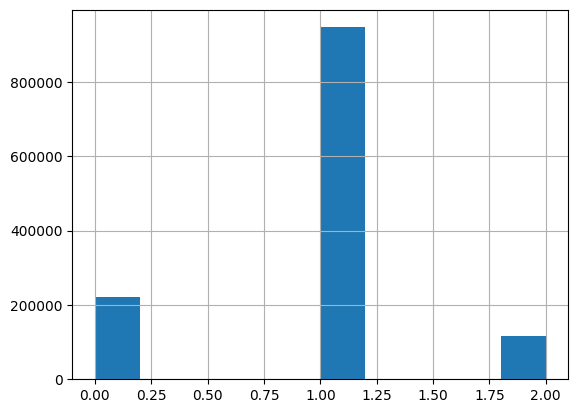

In [ ]:
auto_loader.data.type.hist()# до андерсемплинга

<Axes: >

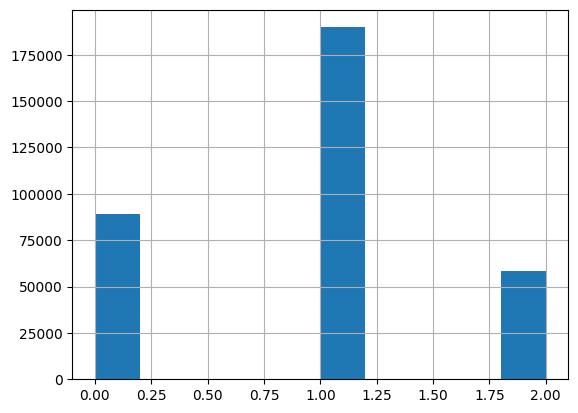

In [ ]:
auto_loader.get_data().type.hist() # после андерсемплинга

### Лемматизация данных

In [ ]:
# def lemmatize_data(texts, texts_count=None, batch_size=1000):
#         if texts_count is not None:
#             texts = texts[:texts_count]
#         lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
#         txtpart = lol(texts, batch_size)
#         res = []
#         mystem = Mystem()
#         for txtp in txtpart:
#             alltexts = ' '.join([txt + ' br ' for txt in txtp])

#             words = mystem.lemmatize(alltexts)
#             doc = ''
#             for txt in words:
#                 if txt != '\n' and txt.strip() != '':
#                     if txt == 'br':
#                         res.append(doc)
#                         doc = ''
#                     else:
#                         doc = doc + ' ' + txt
#         return res

In [ ]:
# pd.DataFrame(auto_loader.get_data()[:85000]).to_csv('/content/drive/MyDrive/vk_antiscience/prepared_data/data1.csv')
# pd.DataFrame(auto_loader.get_data()[85000:170000]).to_csv('/content/drive/MyDrive/vk_antiscience/prepared_data/data2.csv')
# pd.DataFrame(auto_loader.get_data()[170000:255000]).to_csv('/content/drive/MyDrive/vk_antiscience/prepared_data/data3.csv')
# pd.DataFrame(auto_loader.get_data()[255000:]).to_csv('/content/drive/MyDrive/vk_antiscience/prepared_data/data4.csv')

In [ ]:
# text = pd.read_csv('/content/drive/MyDrive/vk_antiscience/prepared_data/data4.csv').tokenized_text

In [ ]:
# lemmatized_text = lemmatize_data(text, batch_size=250)

In [ ]:
# pd.DataFrame(lemmatized_text).to_csv('/content/drive/MyDrive/vk_antiscience/lemmatized_data/lemmatized_data4.csv')

# Классификация

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, test_data, train_ans, test_ans = train_test_split(auto_loader.get_data().text, auto_loader.get_data().type, test_size=0.3, random_state=42, stratify=auto_loader.get_data().type)
train_data, val_data, train_ans, val_ans = train_test_split(train_data, train_ans, test_size=0.05, random_state=42, stratify=train_ans)

In [ ]:
%env PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128

env: PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
import evaluate
import sys
import gzip
from datetime import datetime
import numpy as np
DEVICE = torch.device("cuda")
use_gpu = True

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(list(accuracy.compute(predictions=predictions, references=labels).items()) +
        list(precision.compute(predictions=predictions, references=labels).items()) +
        list(recall.compute(predictions=predictions, references=labels).items())
    )

# results = precision_metric.compute(predictions=predictions, references=references, average='macro')

model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
tokenizer_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
# model_name = '/content/drive/MyDrive/vk_antiscience/models/sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2-2023-12-03_17-07-31/checkpoint-15092'
# tokenizer_name = '/content/drive/MyDrive/vk_antiscience/models/sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2-2023-12-03_17-07-31'
per_device_train_batch_size = 16

num_train_epochs = 3           #Number of epochs
max_length = 512               #Max length for a text input

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)#.to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
modules = [model.bert.embeddings, model.bert.encoder]
# for module in modules:
#     for param in module.parameters():
#         param.requires_grad = False

output_dir = "/content/drive/MyDrive/vk_antiscience/models/sbert_no_duplicates{}".format(datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
print("Save checkpoints to:", output_dir)

#A dataset wrapper, that tokenizes our data on-the-fly
class TokenizedSentencesDataset:
    def __init__(self, data, labels, tokenizer, max_length):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        tokenized_data = self.tokenizer(self.data[idx], truncation=True, padding=True,  max_length=max_length)
        item = {key: torch.tensor(val) for key, val in tokenized_data.items()}
        item['labels'] = self.labels[idx].reshape(-1)
        return item

    def __len__(self):
        return len(self.labels)


train_one_hot = torch.nn.functional.one_hot(torch.tensor(train_ans.to_list()).type('torch.LongTensor')).float()
val_one_hot = torch.nn.functional.one_hot(torch.tensor(val_ans.to_list()).type('torch.LongTensor')).float()
test_one_hot = torch.nn.functional.one_hot(torch.tensor(test_ans.to_list()).type('torch.LongTensor')).float()

train_dataset = TokenizedSentencesDataset(train_data.to_list(), train_one_hot, tokenizer=tokenizer, max_length=max_length)
val_dataset = TokenizedSentencesDataset(val_data.to_list(), val_one_hot, tokenizer=tokenizer, max_length=max_length)
test_dataset = TokenizedSentencesDataset(test_data.to_list(), test_one_hot, tokenizer=tokenizer, max_length=max_length)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=output_dir,
    # learning_rate=2e-5,
    overwrite_output_dir=True,
    num_train_epochs=num_train_epochs,
    evaluation_strategy="epoch",
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_train_batch_size
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Save checkpoints to: /content/drive/MyDrive/vk_antiscience/models/sbert_no_duplicates2023-12-17_16-35-07


In [ ]:
tokenized = tokenizer([' СЕНСАЦИЯ СУПЕРГЕРОИ ВСЕМИРНОГО АНТИФАШИСТСКОГО СОПРОТИВЛЕНИЯ ПРОФЕССОР ЭНДРЮ КАУФМАН И ДЭВИД АЙК ВСКРЫЛИ ЧУДОВИЩНЫЙ ОБМАН НАС КОВИДЦИФРОФАШИСТАМИ НОСИТЕЛИ ГЕНОВ БОГА ЛЮДИ БОГА БУДУТ УНИЧТОЖЕНЫ ИИ ИСКУССТВЕННЫМ ИНТЕЛЛЕКТОМ С ПОМОЩЬЮ МАРКИРОВАННОГО 5G ОРУЖИЯ ВОТ ДЛЯ ЧЕГО САТАНИСТЫ СОБИРАЮТ ДНКПЦРТЕСТЫ И НАШУ БИОМЕТРИЮ 3 ВИДЕО До сих пор ни один ученый не смог изолировать вирус и доказать его существование ПЦР тесты и вся статистика по т н ковид это обман см вирус ВИЧ и другие не существуют научная доказательная база от известных независимых учёных ПЦР тесты ищут носителей специфических генов в 8 хромосоме а не какието несуществующие вирусы Сенсационное откровение профессора Эндрю Кауфмана профессор вирусолог иммунолог и гематолог медицинского университета Южной Каролины Обман Kрода наконецто раскрыт в деталях Профессор Эндрю Кауфман после тщательного анализа маркеров в тестах ПЦР доказывает что эти тесты никоим образом не могут выявить вирус Вот это факт Нет вирусной РНК а только фрагменты человеческой РНК которые ПЦР тестирует Все тесты ПЦР ищут в клетке человека конкретный генетический материал характерный для хромосомы Вот почему эта ПЛАНДЕМИЯ устроилась и столько давления для тестов больше тестов Ищут конкретных носителей генов бога Что за гены В маркерах Квидовые есть праймер который ищет характерный 18базовый код ДНК человека в 8й хромосоме Носители этого конкретного сочетания генома осуждаются как якобы зараженные вирусом или положительно проверенные Носители этих генов бога люди бога будут уничтожены ИИ искусственным интеллектом с помощью маркированного оружия это оружие с целенаправленным действием Оно может уничтожить определенные цели с конкретным генетическим кодом Вот почему им так сильно нужны эти тесты для Covid и биометрия Хуже всего Всемирная организация здравоохранения настаивает на том чтобы разные национальности использовали разные протоколы праймера последовательности ПЦР те ищут разные носители этих специфических генов в разных странах ВОЗ обязала Болгарию использовать тесты ПЦР изготовленные конкретными лабораториями К этому мошенничеству причастны все страны Мошенничество осуществляется с помощью СМИ вызывая страх и панику и колоссальное давление на тесты Видимо очень хорошо спланировано и согласовано Когда это чудовищное преступление будет подробно раскрыто всех участников премьер министров президентов мэров губернаторов генералов врачей СМИ будут судить на новом нюрнбергском трибунале за покушение на человечность см НОВЫЙ НЮРНБЕРГСКИЙ ТРИБУНАЛ для ковидфашистов фронт исполнения наказания для международных преступников нарушающих нюрнбергский кодекс в мире фронт разоблачения лжепандемии и спец операции коронавирус информационноразъяснительный фронт юридическоревизорский юридический народный фронт против ковидфашистов фронт защиты ДНК невмешательства в геном человека неприкосновенности и священности тела человека фронт за отмену ПЦР тестирования фронт за отмену управления людьми ИИ искусственным интеллектом фронт за отмену 5G фронт за отмену биометрии фронт нейтрализации наночипов наночастиц нановакцин ФРОНТ ПО ДЕМОНТАЖУ ВЫШЕК СМЕРТИ 5 ДЖИ И ПО ДЕМОНТАЖУ ВИДЕОКАМЕР НАБЛЮДЕНИЯ И СЛЕЖЕНИЯ '], padding=True, truncation=True, return_tensors='pt')
model.cpu()
model(**tokenized)

SequenceClassifierOutput(loss=None, logits=tensor([[ 6.1664, -6.9885, -6.1555]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
print("Save tokenizer to:", output_dir)
tokenizer.save_pretrained(output_dir)

trainer.train()

print("Save model to:", output_dir)
model.save_pretrained(output_dir)

print("Training done")

In [ ]:
preds = trainer.predict(test_dataset)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
print('accuracy =', accuracy_score(test_ans, np.argmax(preds.predictions, axis=1)))

accuracy = 0.9404869003249674


In [ ]:
print('precision =', precision_score(test_ans, np.argmax(preds.predictions, axis=1), average=None))

precision = [0.92881865 0.95295423 0.91841518]


In [ ]:
print('recall =', recall_score(test_ans, np.argmax(preds.predictions, axis=1), average=None))

recall = [0.92582587 0.95911667 0.90383876]


In [ ]:
print('f1_score =', f1_score(test_ans, np.argmax(preds.predictions, axis=1), average=None))

f1_score = [0.92731985 0.95602552 0.91106867]


In [ ]:
preds.predictions

array([[ 6.1315556, -6.926391 , -6.2051454],
       [-7.2829337,  5.2238173, -5.637282 ],
       [-7.304413 ,  5.085133 , -5.3189173],
       ...,
       [-5.8226666, -6.1255383,  5.38691  ],
       [ 1.6655244, -2.2190611, -2.5011408],
       [-4.576209 ,  3.1433728, -4.1138372]], dtype=float32)

In [ ]:
# from google.colab import files
# files.download('/content/output/sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2-2023-05-07_21-25-06/pytorch_model.bin')

# Тематическое моделирование

### Функции для извлечения представлений тем

In [ ]:
def get_bertopic_words_list(topic_model, has_outlier_cluster=True):
    if has_outlier_cluster:
        return list(map(lambda l: list(map(lambda l: l[0], l)), list(topic_model.get_topics().values())))[1:]
    else:
        return list(map(lambda l: list(map(lambda l: l[0], l)), list(topic_model.get_topics().values())))


def get_lda_words_list(topic_model, num_words=10):
    return list(map(lambda l: list(map(lambda l: l[0], l)), list(map(lambda x: x[1], topic_model.show_topics(formatted=False, num_topics=num_topics, num_words=num_words)))))[1:]

In [ ]:
def get_topic_samples(texts, topics, topic_idx, n_samples=20):
    bert_topics_data = pd.DataFrame(topics, columns=['topics']).join(texts)[['topics', 'lemmatized_data', 'tokenized_text', 'pub_name', 'text']]
    return bert_topics_data[bert_topics_data.topics == topic_idx].sample(n_samples)

## Negative class BERT Topic Modeling applied to positive class

In [ ]:
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP


sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = sentence_model.encode(list(auto_loader.get_data()[auto_loader.get_data().type == 0.0].lemmatized_data), show_progress_bar=True)

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=42)
# Clustering model
hdbscan_model = HDBSCAN(min_cluster_size=300, metric='euclidean', prediction_data=True)
# Topic representation model
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, ctfidf_model=ctfidf_model, language='russian')
# Run BERTopic model
topics_bert, probabilities = topic_model.fit_transform(list(auto_loader.get_data()[auto_loader.get_data().type == 0.0].lemmatized_data), embeddings)


Batches:   0%|          | 0/2793 [00:00<?, ?it/s]

In [ ]:
new_topics = topic_model.reduce_outliers(list(auto_loader.get_data()[auto_loader.get_data().type == 0.0].lemmatized_data), topics_bert, strategy="embeddings", embeddings=embeddings)
topic_model.update_topics(list(auto_loader.get_data()[auto_loader.get_data().type == 0.0].lemmatized_data), topics=new_topics, ctfidf_model=ctfidf_model)

2024-05-26 13:07:28,188 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
topic_model.visualize_topics()

In [ ]:
# topic_model.update_topics(list(auto_loader.get_data()[auto_loader.get_data().type == 0.0].lemmatized_data), topics=topics_bert, ctfidf_model=ctfidf_model)

2024-05-23 19:18:59,574 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,9792,0_здоровье_медицинский_медицина_обозрение,"[здоровье, медицинский, медицина, обозрение, о...",[ народный способ лечение болезнь сли у вы бол...
1,1,9448,1_ты_женщина_мужчина_себя,"[ты, женщина, мужчина, себя, любовь, отношение...",[ исцелять цитата психотерапевт илс санд самый...
2,2,7618,2_земля_плоский_космос_луна,"[земля, плоский, космос, луна, солнце, шар, пл...",[ свастика солнце число во многий страна религ...
3,3,4272,3_ть_пр_чт_эта,"[ть, пр, чт, эта, ст, ния, го, ет, св, ни]",[ энергетический п р зита м ло кто из люд й о ...
4,4,3278,4_вакцина_вакцинация_вирус_коронавирус,"[вакцина, вакцинация, вирус, коронавирус, прив...",[ впервые в русский научный литература появлят...
5,5,4757,5_россия_русский_история_историяроссия,"[россия, русский, история, историяроссия, ссср...",[ за что убивать м в ломоносов видео главный т...
6,6,2071,6_масло_добавлять_блендер_соль,"[масло, добавлять, блендер, соль, ложка, приго...",[ морковный торт с апельсиновый миндальный кре...
7,7,3684,7_психология_мозг_человек_мысль,"[психология, мозг, человек, мысль, самопознани...",[ как развивать в себя ясновидение развитие эк...
8,8,1666,8_инопланетянин_пришелец_нло_уфология,"[инопланетянин, пришелец, нло, уфология, внезе...",[ древний изображение нло и пришелец подробно ...
9,9,3048,9_технология_наука_энергия_физика,"[технология, наука, энергия, физика, ученый, р...",[ ссср почти во весь воровать и покупать техно...


In [ ]:
get_bertopic_words_list(topic_model, has_outlier_cluster=False)

In [ ]:
get_bertopic_words_list(topic_model, has_outlier_cluster=False)[0]

['здоровье',
 'медицинский',
 'медицина',
 'обозрение',
 'организм',
 'новость',
 'заболевание',
 'болезнь',
 'продукт',
 'лечение']

In [ ]:
get_topic_samples(auto_loader.get_data()[auto_loader.get_data().type == 0.0], topics_bert, 0, n_samples=5)

,topics,lemmatized_data,tokenized_text,pub_name,text
21238,0,история женщина который умирать и вернуться к...,ИСТОРИЯ ЖЕНЩИНЫ КОТОРАЯ УМЕРЛА И ВЕРНУЛАСЬ К Ж...,Сыроедение - Я ФРУКТОРИАНЕЦ,"ИСТОРИЯ ЖЕНЩИНЫ, КОТОРАЯ УМЕРЛА И ВЕРНУЛАСЬ К ..."
29502,0,главный врач клиника консуэло аширов обидно у...,Главный врач клиники Консуэло АШИРОВА Обидно у...,Вся Правда о Здоровье,Главный врач клиники Longa Vita Консуэло АШИРО...
25349,0,работа с мембрана голень важный практика наве...,РАБОТА С МЕМБРАНОЙ ГОЛЕНИ ВАЖНЕЙШАЯ ПРАКТИКА Н...,Школа народной медицины Славица,РАБОТА С МЕМБРАНОЙ ГОЛЕНИ — ВАЖНЕЙШАЯ ПРАКТИКА...
23049,0,я решать становиться веган именно из любовь к...,Я решил стать веганом именно из любви к животн...,"FRESH & FRESH. Сыроедение, веганство","""Я решил стать веганом именно из любви к живот..."
30589,0,прибежище лимфом в россия использовать опасны...,Прибежище лимфомы в России используют опасные ...,Вся Правда о Здоровье,Прибежище лимфомы: в России используют опасные...


In [ ]:
N_by_AN_topics, N_by_AN_probs = topic_model.transform(list(auto_loader.get_data()[auto_loader.get_data().type == 2.0].lemmatized_data))

In [ ]:
get_topic_samples(auto_loader.get_data()[auto_loader.get_data().type == 2.0].reset_index(drop=True), N_by_AN_topics, 0, n_samples=5)

,topics,lemmatized_data,tokenized_text,pub_name,text
13304,0,ахилловый сухожилие человек подмикроскоп увел...,Ахиллово сухожилие человека подмикроскопом Уве...,Телеканал Доктор,Ахиллово сухожилие человека #подмикроскопом. У...
25259,0,росздравнадзор предупреждать о временный дефи...,Росздравнадзор предупредил о временном дефицит...,Доказательная медицина,Росздравнадзор предупредил о временном дефицит...
22411,0,розовый октябрь месяц осведомленность о рак м...,Розовый октябрь месяц осведомленности о раке м...,Фонд медицинских решений «Не напрасно!»,«Розовый октябрь» – месяц осведомленности о ра...
37277,0,редкий мутация у жительница шотландия подавля...,Редкая мутация у жительницы Шотландии подавила...,Образовач,Редкая мутация у жительницы Шотландии подавила...
24555,0,необходимый лекарство в ваш аптечка врач ники...,необходимых лекарств в вашей аптечке Врач Ники...,Доказательная медицина,15 необходимых лекарств в вашей аптечке. Врач ...


In [ ]:
def generate_samples_N_by_AN(topics_AN, topics_N_by_AN, cnt=5):
    topics_AN_cnt = pd.DataFrame(topics_AN).nunique().iloc[0]
    print(topics_AN_cnt)
    topics_blacklist = [3, 30]
    result = pd.DataFrame([], columns=['topic_antiscience', 'text_antiscience', 'topic_science', 'text_science'])
    for i in range(cnt):
        topic = random.randint(0, topics_AN_cnt - 1)
        while topic in topics_blacklist:
            topic = random.randint(0, topics_AN_cnt - 1)
        curr_result = pd.DataFrame([('_'.join(get_bertopic_words_list(topic_model, has_outlier_cluster=False)[topic]),
                                    get_topic_samples(auto_loader.get_data()[auto_loader.get_data().type == 0.0], topics_AN, topic, n_samples=1).text.iloc[0],
                                    '_'.join(get_bertopic_words_list(topic_model, has_outlier_cluster=False)[topic]),
                                    get_topic_samples(auto_loader.get_data()[auto_loader.get_data().type == 2.0].reset_index(drop=True), topics_N_by_AN, topic, n_samples=1).text.iloc[0])
                                    ],\
                        columns=['topic_antiscience', 'text_antiscience', 'topic_science', 'text_science'])
        result = pd.concat([result, curr_result])
    return result.reset_index(drop=True)

samples_N_by_AN = generate_samples_N_by_AN(new_topics, N_by_AN_topics, cnt=50)

36


In [ ]:
samples_N_by_AN

,topic_antiscience,text_antiscience,topic_science,text_science
0,психология_мозг_человек_мысль_самопознание_соз...,ПРАКТИКИ И УПРАЖНЕНИЯ НА ЧУВСТВИТЕЛЬНОСТЬ РУК....,психология_мозг_человек_мысль_самопознание_соз...,■ КОНКУРС | БИО/МОЛ/ТЕКСТ-2019 ■ НОМИНАЦИЯ | ...
1,ты_мужчина_женщина_себя_любовь_отношение_любит...,"Кᴏгдa ты счaстлив, нельзя ʜикому об этoм расск...",ты_мужчина_женщина_себя_любовь_отношение_любит...,С праздником милые Женщины🤍 Каждая из нас у...
2,китай_китайский_китаец_япония_рейтинг_подробно...,🇨🇳 Китай съест значительную часть нашей террит...,китай_китайский_китаец_япония_рейтинг_подробно...,Южная Корея предложила Китаю вместе вызывать и...
3,криптозоология_динозавр_рептилоид_змея_дракон_...,Пришедшие со звёзд: теория Дарвина — сомнитель...,криптозоология_динозавр_рептилоид_змея_дракон_...,Еще одна мумия динозавра полностью потеряна дл...
4,загадкиистория_история_подробно_нло_альтернати...,Боевые псы. Античность Подробнее: https://sal...,загадкиистория_история_подробно_нло_альтернати...,"Новый выпуск ""Человека читающего"" от проекта [..."
5,инопланетянин_пришелец_нло_уфология_внеземныец...,"Летающие тарелки, инопланетяне, скрытая импери...",инопланетянин_пришелец_нло_уфология_внеземныец...,Парадокс Ферми: почему молчит Вселенная? Что...
6,масло_добавлять_блендер_соль_ложка_приготовлен...,~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 🌼[club3333...,масло_добавлять_блендер_соль_ложка_приготовлен...,А как вы готовите яичницу ? #РБВ@chemistryeasyru
7,сон_сновидение_спать_вещий_просыпаться_упражне...,"Людей, находящихся в самоизоляции, начали посе...",сон_сновидение_спать_вещий_просыпаться_упражне...,"«Чтобы выявить первичную функцию сна, ученые и..."
8,россия_русский_история_историяроссия_ссср_слав...,Журнал Минобороны сообщил о существовании в Ро...,россия_русский_история_историяроссия_ссср_слав...,Уже с середины 30-х гг. практика культивирован...
9,антарктида_планетаземля_климатземля_лед_разлом...,Первое великое переселение народов Подробнее:...,антарктида_планетаземля_климатземля_лед_разлом...,Астрономы заподозрили существование ледяного г...


In [ ]:
pd.DataFrame(samples_N_by_AN).to_csv('/content/drive/MyDrive/vk_antiscience/results_data/samples_N_by_AN.csv')

In [ ]:
len(N_by_AN_topics)

58509

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart(top_n_topics=15)

## Topics matching by similarity

In [ ]:
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=42)
# Clustering model
hdbscan_model = HDBSCAN(min_cluster_size=250, metric='euclidean', prediction_data=True)
# Topic representation model
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
# Initiate BERTopic
topic_model_science = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, ctfidf_model=ctfidf_model, language='russian')
# Run BERTopic model
topics_bert_science, probabilities_science = topic_model_science.fit_transform(list(auto_loader.get_data()[auto_loader.get_data().type == 2.0].lemmatized_data))

In [ ]:
new_topics_science = topic_model_science.reduce_outliers(list(auto_loader.get_data()[auto_loader.get_data().type == 2.0].lemmatized_data), topics_bert_science, strategy="embeddings")
topic_model_science.update_topics(list(auto_loader.get_data()[auto_loader.get_data().type == 2.0].lemmatized_data), topics=new_topics_science, ctfidf_model=ctfidf_model)

2024-05-26 10:57:42,640 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
topic_model_science.visualize_topics()

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,9792,0_здоровье_медицинский_медицина_обозрение,"[здоровье, медицинский, медицина, обозрение, о...",[ народный способ лечение болезнь сли у вы бол...
1,1,9448,1_ты_женщина_мужчина_себя,"[ты, женщина, мужчина, себя, любовь, отношение...",[ исцелять цитата психотерапевт илс санд самый...
2,2,7618,2_земля_плоский_космос_луна,"[земля, плоский, космос, луна, солнце, шар, пл...",[ свастика солнце число во многий страна религ...
3,3,4272,3_ть_пр_чт_эта,"[ть, пр, чт, эта, ст, ния, го, ет, св, ни]",[ энергетический п р зита м ло кто из люд й о ...
4,4,3278,4_вакцина_вакцинация_вирус_коронавирус,"[вакцина, вакцинация, вирус, коронавирус, прив...",[ впервые в русский научный литература появлят...
5,5,4757,5_россия_русский_история_историяроссия,"[россия, русский, история, историяроссия, ссср...",[ за что убивать м в ломоносов видео главный т...
6,6,2071,6_масло_добавлять_блендер_соль,"[масло, добавлять, блендер, соль, ложка, приго...",[ морковный торт с апельсиновый миндальный кре...
7,7,3684,7_психология_мозг_человек_мысль,"[психология, мозг, человек, мысль, самопознани...",[ как развивать в себя ясновидение развитие эк...
8,8,1666,8_инопланетянин_пришелец_нло_уфология,"[инопланетянин, пришелец, нло, уфология, внезе...",[ древний изображение нло и пришелец подробно ...
9,9,3048,9_технология_наука_энергия_физика,"[технология, наука, энергия, физика, ученый, р...",[ ссср почти во весь воровать и покупать техно...


In [ ]:
new_topics_science = topic_model_science.reduce_outliers(list(auto_loader.get_data()[auto_loader.get_data().type == 2.0].lemmatized_data), topics_bert_science, probabilities=probabilities_science, strategy="probabilities")
topic_model_science.update_topics(list(auto_loader.get_data()[auto_loader.get_data().type == 2.0].lemmatized_data), topics=new_topics_science, ctfidf_model=ctfidf_model)

2024-05-10 20:22:39,997 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
get_bertopic_words_list(topic_model_science, has_outlier_cluster=False)[3]

['депрессия',
 'психология',
 'отношение',
 'психолог',
 'психологический',
 'личность',
 'психотерапия',
 'когнитивный',
 'расстройство',
 'психический']

In [ ]:
get_topic_samples(auto_loader.get_data()[auto_loader.get_data().type == 2.0].reset_index(drop=True), topics_bert_science, 3, n_samples=5)

,topics,lemmatized_data,tokenized_text,pub_name,text
41141,3,эколог выяснять что чайка приспосабливаться к...,Экологи выяснили что чайки приспособились к ан...,Образовач,"Экологи выяснили, что чайки приспособились к а..."
30741,3,дождалисить опубликовывать подробный филогене...,Дождалися Опубликовано подробное филогенетичес...,The Batrachospermum Magazine,Дождалися!!! Опубликовано подробное филогенети...
44819,3,второй вход в муравейник понижать эффективнос...,Второй вход в муравейнике понизил эффективност...,Образовач,Второй вход в муравейнике понизил эффективност...
37658,3,мезозойский многоножка в бирманский янтарь ок...,Мезозойская многоножка в бирманском янтаре ока...,Образовач,Мезозойская многоножка в бирманском янтаре ока...
27428,3,в сша выпускать в природа генетически модифиц...,В США выпустили в природу генетически модифици...,НаучпопScienceArt Популяризация науки и искусств,В США выпустили в природу генетически модифици...


In [ ]:
import seaborn as sns

In [ ]:
def match_topics(topics_1, topics_2, similarity_thr=0.0):
    similarity_matrix = np.zeros((len(topics_1), len(topics_2)))
    for idx_1 in range(len(topics_1)):
        for idx_2 in range(len(topics_2)):
            similarity_matrix[idx_1, idx_2] = len(set(topics_1[idx_1]).intersection(set(topics_2[idx_2]))) / len(topics_1[idx_1])

    sns.heatmap(similarity_matrix, cmap="crest")
    matching = np.argmax(similarity_matrix, axis=1)
    score = np.max(similarity_matrix, axis=1)
    for idx_1 in range(len(topics_1)):
        if score[idx_1] > similarity_thr:
            print('_'.join(topics_1[idx_1]), '<=>', '_'.join(topics_2[matching[idx_1]]), 'score =', score[idx_1], '\n')
        else:
            print(idx_1, '_'.join(topics_1[idx_1]), '- no match', 'score =', score[idx_1], '\n')
    return matching


In [ ]:
# 3, 5, 6, 8, 12, 13, 14, 15, 16, 19, 20, 23, 25, 27, 28, 34

здоровье_медицинский_медицина_обозрение_организм_новость_заболевание_болезнь_продукт_лечение <=> врач_пациент_лечение_рак_медицина_не_препарат_операция_это_ребенок score = 0.2 

ты_женщина_мужчина_себя_любовь_отношение_жизнь_любить_вы_она <=> читать_как_социальный_человек_отношение_свой_мы_что_вы_то score = 0.2 

земля_плоский_космос_луна_солнце_шар_планета_космический_горизонт_гравитация <=> космический_звезда_луна_космос_астроном_планета_дыра_галактика_телескоп_земля score = 0.5 

3 ть_пр_чт_эта_ст_ния_го_ет_св_ни - no match score = 0.0 

вакцина_вакцинация_вирус_коронавирус_прививка_ковид_пандемия_эпидемия_воз_вакцинировать <=> коронавирус_вирус_коронавирусный_инфекция_пандемия_заражение_эпидемия_гепатит_грипп_вирусный score = 0.4 

5 россия_русский_история_историяроссия_ссср_славянин_загадкиистория_еврей_российский_русь - no match score = 0.0 

6 масло_добавлять_блендер_соль_ложка_приготовление_ингредиент_рецепт_орех_кокосовый - no match score = 0.0 

психология_мозг_человек_мысль_

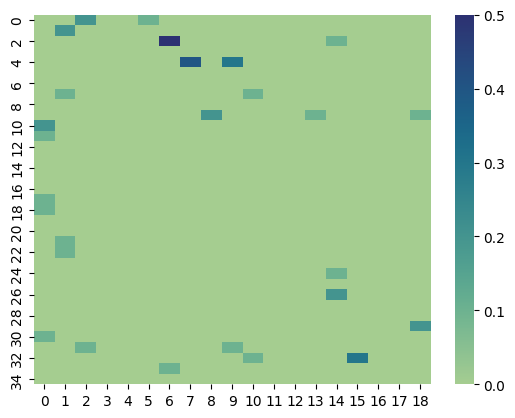

In [ ]:
matching = match_topics(get_bertopic_words_list(topic_model, has_outlier_cluster=False), get_bertopic_words_list(topic_model_science, has_outlier_cluster=False))

In [ ]:
matching

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [ ]:
def generate_samples_topics_matching(topics_AN, topics_N, matching, cnt=5):
    topics_AN_cnt = pd.DataFrame(topics_AN).nunique().iloc[0]
    print(topics_AN_cnt)
    topics_blacklist = [3, 5, 6, 8, 12, 13, 14, 15, 16, 19, 20, 23, 25, 27, 28, 34]
    # topics_blacklist = [3, 8, 10, 12, 16, 17, 20, 21, 22, 25, 26, 28]
    result = pd.DataFrame([], columns=['topic_antiscience', 'text_antiscience', 'topic_science', 'text_science'])
    for i in range(cnt):
        topic = random.randint(0, topics_AN_cnt - 1)
        while topic in topics_blacklist:
            topic = random.randint(0, topics_AN_cnt - 1)
        matched_topic = matching[topic]
        curr_result = pd.DataFrame([('_'.join(get_bertopic_words_list(topic_model, has_outlier_cluster=False)[topic]),
                                    get_topic_samples(auto_loader.get_data()[auto_loader.get_data().type == 0.0], topics_AN, topic, n_samples=1).text.iloc[0],
                                    '_'.join(get_bertopic_words_list(topic_model_science, has_outlier_cluster=False)[matched_topic]),
                                    get_topic_samples(auto_loader.get_data()[auto_loader.get_data().type == 2.0].reset_index(drop=True), topics_N, matched_topic, n_samples=1).text.iloc[0])
                                    ],\
                        columns=['topic_antiscience', 'text_antiscience', 'topic_science', 'text_science'])
        result = pd.concat([result, curr_result])
    return result.reset_index(drop=True)

samples_topics_matching = generate_samples_topics_matching(new_topics, topics_bert_science, matching, cnt=50)

35


In [ ]:
samples_topics_matching

,topic_antiscience,text_antiscience,topic_science,text_science
0,земля_плоский_космос_луна_солнце_шар_планета_к...,Этот путь составляет 111 120 км (20 000 лье). ...,космический_звезда_луна_космос_астроном_планет...,Астрономы измерили расстояние до первого кольц...
1,здоровье_медицинский_медицина_обозрение_органи...,"Височно-нижнечелюстной сустав – это сустав, на...",врач_пациент_лечение_рак_медицина_не_препарат_...,"Участились вопросы на личные темы, тревоги и с..."
2,китай_китайский_китаец_япония_рейтинг_подробно...,Перед вами одно из интервью Сороса от 2009 год...,читать_как_социальный_человек_отношение_свой_м...,Понимание современного общества и перспектив е...
3,загадкицивилизация_артефакт_древний_загадочные...,Железная морская улитка. Раковина покрыта желе...,древний_год_наш_череп_из_реконструкция_кость_а...,Посмотрите какие крутые копии окаменелостей де...
4,здоровье_медицинский_медицина_обозрение_органи...,Супрун побеспокоилась о сердцах украинцев Гла...,врач_пациент_лечение_рак_медицина_не_препарат_...,27 сентября в 20:00 на радио «Медиаметрикс» [c...
5,психология_мозг_человек_мысль_самопознание_сам...,"У каждого человека, есть своя аура – своеобраз...",читать_как_социальный_человек_отношение_свой_м...,Проблема кризиса среднего возраста в настоящее...
6,вакцина_вакцинация_вирус_коронавирус_прививка_...,"Губернатор штата Нью-Йорк Эндрю Куомо, участву...",коронавирус_вирус_коронавирусный_инфекция_панд...,#ОРВИ #эпидемиология В США расширяется програм...
7,технология_наука_энергия_физика_ученый_робот_п...,"Физик А.Золотарев о ""двойных стандартах"" в офи...",наука_научный_миф_ученый_упм_форум_книга_проти...,"Не так давно в комментариях увидел, что люди ж..."
8,земля_плоский_космос_луна_солнце_шар_планета_к...,Уснувший рейс: как маленький переключатель пог...,космический_звезда_луна_космос_астроном_планет...,Астрономы получили качественные снимки 26 обло...
9,технология_наука_энергия_физика_ученый_робот_п...,В Швейцарии начали строительство Матрицы. Прое...,наука_научный_миф_ученый_упм_форум_книга_проти...,Сегодня мы поздравляем с днем рождения палеонт...


In [ ]:
pd.DataFrame(samples_topics_matching).to_csv('/content/drive/MyDrive/vk_antiscience/results_data/samples_topics_matching5.csv')